# Homotopic optimal control of inverted pendulum

## Dynamics

In [ ]:
from sympy import *
init_printing()

In [ ]:
# state variables
x, v, theta, omega = symbols("x v \\theta, \\omega", real=True)
s = Matrix([x, v, theta, omega])
s.T

In [ ]:
# control parameter
u = symbols('u', real=True, nonzero=True)

# state equations of motion
ds = Matrix([v, u, omega, sin(theta) - u*cos(theta)])
ds

In [ ]:
# homotopy parameters
alpha, beta = symbols('\\alpha \\beta', real=True, nonegative=True)

# homotopy between effort and time
L = beta + (1-beta)*abs(u)

# homotopy between energy and effort/time
L = alpha*L + (1-alpha)*u**2
L

In [ ]:
# costate variables
l = Matrix(symbols(['\\lambda_{' + str(var) + '}' for var in s]), real=True, nonzero=True)
l.T

In [ ]:
# Hamiltonian
H = l.dot(ds) + L
H

In [ ]:
# costate equations of motion
dl = -H.diff(s)
dl

In [ ]:
# optimal control; note that alpha dissappears
# because effort and time optimality are equivalent in this case
us = solve(H.diff(u), u)[0]
us

In [ ]:
# effort/time optimal control (bang-bang)
us.subs(alpha, 1)

## Base trajectory
We first solve for a base trajectory, which will subsequently be used to iniate the forthcoming homotopy sequence approach to reaching the difficultly found bang-bang optimal control.

In [1]:
import sys, numpy as np, matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
sys.path.append('../src/')
from pendulum import Pendulum
%matplotlib inline

In [2]:
# instantiate problem
seg = Pendulum()

# solve arguments
s0 = [0,0,np.pi,0]
alpha = 0
Tlb = 5
Tub = 15
lb = 1

In [3]:
# solve
zg = None
zg = [10.21795266,  0.19885557,  0.77306339,  0.99997456,  0.83067696]
#zg = [6.12032571, 0.03676911, 0.90012948, 1.40507211, 0.39248787]
while True:
    z, f, feas = seg.solve(s0, alpha, Tlb, Tub, lb, z=zg)
    if feas:
        break
z

array([10.21795266,  0.19885557,  0.77306339,  0.99997456,  0.83067696])

In [4]:
# simulate the solution's resultant trajectory
tl, sl, ul = seg.propagate(z[0], s0, z[1:], alpha, atol=1e-12, rtol=1e-12, u=True)

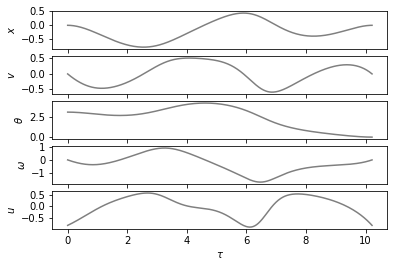

In [5]:
# plot states and control
fig, ax = seg.plot_states(tl, sl, ul)

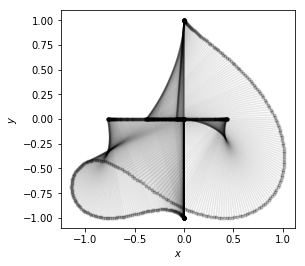

In [6]:
# plot geometric trajectory
fig, ax = seg.plot_traj(tl, sl)

## Policy homotopy

```python
zo = None
a = 0
while a < 1:
    z = solve(zo, a)
    if succesfull(z):
        zo = z
        a = increase(a)
    else:
        a = decrease(a)
```

## Forward homotopy $\alpha: 0 \rightarrow 1$
This brings us to a bang-bang policy with an appropriate magnitude, which is realisable from the original quadratic policy.

In [7]:
#sols = seg.homotopy(s0, 0, Tlb, Tub, 10, z, 1, step=0.001)
sols = np.load("ph.npy")

In [8]:
#np.save('ph.npy', np.flip(sols, axis=0))

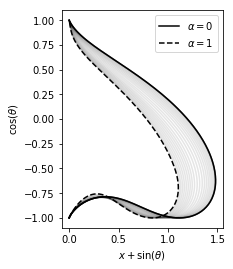

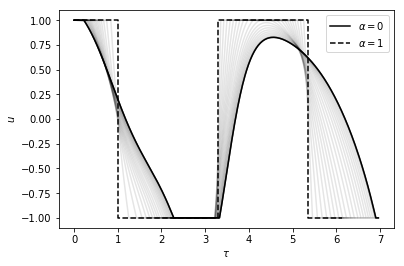

In [9]:
# plot the forward homotopy 
fig, ax = plt.subplots(1)
fig1, ax1 = plt.subplots(1)
for i in range(len(sols)):
    z = sols[i][0]
    a = sols[i][1]
    seg.alpha = a
    tl, sl, ul = seg.propagate(z[0], s0, z[1:], a, u=True)
    x = sl[:,0] + np.sin(sl[:,2])
    y = np.cos(sl[:,2])
    if a == 0:
        ax.plot(x, y, "k-", alpha=1, label=r"$\alpha=0$")
        ax1.plot(tl, ul, "k-", alpha=1, label=r"$\alpha=0$")
    elif a == 1:
        ax.plot(x, y, "k--", alpha=1, label=r"$\alpha=1$")
        ax1.plot(tl, ul, "k--", alpha=1, label=r"$\alpha=1$")
    else:
        ax.plot(x, y, "k-", alpha=0.1)
        ax1.plot(tl, ul, "k-", alpha=0.1)
ax.set_aspect('equal')
ax.legend()
ax1.legend()
ax.set_xlabel(r"$x + \sin\left(\theta\right)$")
ax.set_ylabel(r"$\cos\left(\theta\right)$")
ax1.set_xlabel(r'$\tau$')
ax1.set_ylabel(r'$u$')
plt.show()
fig.savefig("phs.pdf", bbox_inches='tight')
fig1.savefig("phu.pdf", bbox_inches='tight')

## Random walks

```python
T = []
so = snom
zo = znom
while len(T) < N:
    s = perturb(so, ds)
    z = solve(s, zo)
    if succesfull(z):
        so = s
        zo = z
        T.append((so, zo))
        ds = increase(ds)
    else:
        ds = decrease(ds)
        
```

In [10]:
# arguments
so = s0
zo = zg
zo = sols[0][0]
alpha = 0
n = 10
Tlb = 0
Tub = 15
lb = 5
nw = 8

# random walks
T = seg.random_walk_par(so, zo, alpha, n, Tlb, Tub, lb, nw, dsm=0.02, verbose=True)
#T = np.load('pqdb.npy')

Success 1. Step sice now 0.02
Success 1. Step sice now 0.02
Success 1. Step sice now 0.02
Success 1. Step sice now 0.02
Success 1. Step sice now 0.02
Success 1. Step sice now 0.02
Success 1. Step sice now 0.02
Success 1. Step sice now 0.02
Success 2. Step sice now 0.02
Success 2. Step sice now 0.02
Success 2. Step sice now 0.02
Success 2. Step sice now 0.02
Success 2. Step sice now 0.02
Success 2. Step sice now 0.02
Success 2. Step sice now 0.02
Success 2. Step sice now 0.02
Success 3. Step sice now 0.02
Success 3. Step sice now 0.02
Success 3. Step sice now 0.02
Success 3. Step sice now 0.02
Success 3. Step sice now 0.02
Success 3. Step sice now 0.02
Success 3. Step sice now 0.02
Success 3. Step sice now 0.02
Success 4. Step sice now 0.02
Success 4. Step sice now 0.02
Success 4. Step sice now 0.02
Success 4. Step sice now 0.02
Success 4. Step sice now 0.02
Success 4. Step sice now 0.02
Success 4. Step sice now 0.02
Success 5. Step sice now 0.02
Success 4. Step sice now 0.02
Success 5.

In [ ]:
#np.save('pqdb.npy', T)

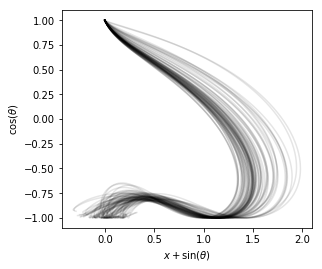

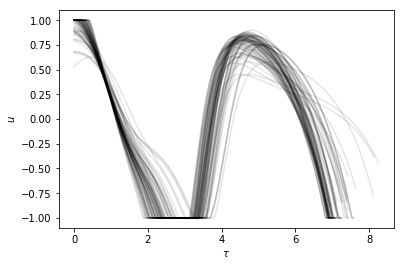

In [11]:
# plot the random walks
fig, ax = plt.subplots(1)
fig1, ax1 = plt.subplots(1)

# for each random walk
first = False
for t in T:
    
    # initial state
    s0 = t[0]
    
    # decision vector
    z = t[1]
    
    # simulate trajectory
    tl, sll, ul = seg.propagate(z[0], s0, z[1:], alpha, u=True)
    
    # endpoints
    x = sll[:,0] + np.sin(sll[:,2])
    y = np.cos(sll[:,2])
    
    # plot
    if first:
        ax.plot(x, y, "k-", alpha=1, label="Nominal")
        ax1.plot(tl, ul, "k-", alpha=1, label="Nominal")
        first = False
    else:
        ax.plot(x, y, "k-", alpha=0.1)
        ax1.plot(tl, ul, "k-", alpha=0.1)
ax.set_aspect('equal')
#ax.legend()
#ax1.legend()
ax.set_xlabel(r'$f$')
ax.set_xlabel(r"$x + \sin\left(\theta\right)$")
ax.set_ylabel(r"$\cos\left(\theta\right)$")
ax1.set_xlabel(r'$\tau$')
ax1.set_ylabel(r'$u$')
plt.show()
#fig.savefig('pqdbs.pdf', bbox_inches='tight')
#fig1.savefig('pqdbu.pdf', bbox_inches='tight')

## Database homotopy

In [ ]:
res = seg.homotopy_db(T, 0, 0, 15, 5, 1, step=0.01)
#res = np.load('pqhdb.npy')

z=[ 6.91785248  0.27595741  0.37684861 -1.09711013 -3.15960338]
a=0.0
z=[ 7.20222484  0.18443183  0.17473792 -0.78703992 -2.71843245]
a=0.0
z=[ 6.90849646  0.30882723  0.24495862 -1.11947634 -2.65349971]
a=0.0
z=[ 8.24951957  0.15882409  0.4399483   0.37398505 -2.23750639]
a=0.0
z=[ 6.94087534  0.31816824  0.29939319 -1.0793691  -2.61645269]
a=0.0
z=[ 6.96209278  0.33095384  0.2943599  -1.11307475 -2.53239128]
a=0.0
z=[ 6.86748369  0.35996274  0.43539165 -1.19490013 -2.95374256]
a=0.0
z=[ 6.91119973  0.27329894  0.36858944 -1.09808685 -3.13085713]
a=0.01
z=[ 6.89295126  0.29245009  0.28032808 -1.0725742  -2.83755452]
a=0.0
z=[ 6.90341111  0.30571579  0.23770666 -1.1184951  -2.62879171]
a=0.01
z=[ 7.19742766  0.18269694  0.17063575 -0.78553277 -2.69181758]
a=0.01
z=[ 6.9359498   0.31500171  0.2919497  -1.07823439 -2.59195281]
a=0.01
z=[ 6.86129443  0.35647732  0.4255994  -1.19599648 -2.92803969]
a=0.01
z=[ 6.95744856  0.32763587  0.28691207 -1.11142639 -2.50852524]
a=0.01
z=[ 6.90452184

z=[ 6.89792666  0.28746174  0.19854683 -1.08701956 -2.22121355]
a=0.12999999999999998
z=[ 8.00353093  0.15478327  0.36795306  0.18271861 -2.05200686]
a=0.09999999999999999
z=[ 6.78192394  0.31407519  0.30856117 -1.2050558  -2.61867312]
a=0.12999999999999998
z=[ 6.81489018  0.25420499  0.18337448 -1.06861082 -2.49737919]
a=0.12999999999999998
z=[ 6.86705188  0.27339531  0.19617367 -1.05859173 -2.27235263]
a=0.13999999999999999
z=[ 6.8323482   0.26479818  0.14445199 -1.10078928 -2.30638595]
a=0.13999999999999999
z=[ 7.12569698  0.15808113  0.11461981 -0.75881895 -2.31834081]
a=0.15
z=[ 6.80273848  0.23263775  0.24575169 -1.10577391 -2.69778977]
a=0.16
z=[ 6.89260464  0.28408204  0.19126238 -1.08460412 -2.19719288]
a=0.13999999999999999
z=[ 6.8084189   0.25122162  0.17597562 -1.06794854 -2.47111603]
a=0.13999999999999999
z=[ 6.86137544  0.27015885  0.18892449 -1.05660789 -2.24766556]
a=0.15
z=[ 6.79484552  0.22987072  0.23763724 -1.10579767 -2.66879177]
a=0.17
z=[ 7.1201818   0.15629899  

In [ ]:
#np.save('pqhdb.npy', res)

In [ ]:
fig, ax = plt.subplots(1)
fig1, ax1 = plt.subplots(1)

for r in res:
    
    # initial state
    s0 = r[0]
    
    # decision vector
    z = r[1]
    
    # homotopy parameter
    alpha = r[2]
    
    # simulate trajectory
    tl, sll, ul = seg.propagate(z[0], s0, z[1:], alpha, u=True)
    
    # endpoints
    x = sll[:,0] + np.sin(sll[:,2])
    y = np.cos(sll[:,2])
    
    # plot
    if alpha > 1.2:
        ax.plot(x, y, "k--", alpha=1)
        ax1.plot(tl, ul, "k--", alpha=1)
    else:
        ax.plot(x, y, "k-", alpha=0.01)
        ax1.plot(tl, ul, "k-", alpha=0.01)
ax.set_aspect('equal')
    
plt.show()    
#fig1.savefig('phdbu.pdf')

# Training a neural network

In [ ]:
from ann import *

In [ ]:
# generate the databases
#data = seg.gen_db(res, cat=True)
data = np.load('pqhanndb.npy')

In [ ]:
# save the database
#np.save('pqhanndb.npy', data)

In [ ]:
# format the data for the ann
db = Data(data, [0, 1, 2, 3, 4], [5])

In [ ]:
# instantiate the neural network
mlp = Pendulum_Controller([5, 40, 40, 40, 1])

In [ ]:
mlp.train(db.i, db.o, epo=500, lr=1e-4)

In [ ]:
fig, ax = plt.subplots(1)
ax.plot(mlp.ltrn, "k-")
ax.plot(mlp.ltst, "k--")
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

## Simulating the neural network controller

In [ ]:
fig, ax = plt.subplots(1)
fig1, ax1 = plt.subplots(1)
s0 = np.array([0, 0, np.pi, 0])
n = 10
for alpha, alphac in zip(np.linspace(0, 1, n), np.linspace(0.2, 0.8, n)):
    T = 6.5
    tl, sl, ul = seg.propagate_controller(T, s0, mlp.predict, alpha, atol=1e-13, rtol=1e-13)
    x = sl[:,0] + np.sin(sl[:,2])
    y = np.cos(sl[:,2])
    ax.plot(x, y, "k-", alpha=alphac)
    ax1.plot(tl, ul, "k-", alpha=alphac)
ax.set_aspect('equal')
ax.set_xlabel(r'$f$')
ax.set_xlabel(r"$x + \sin\left(\theta\right)$")
ax.set_ylabel(r"$\cos\left(\theta\right)$")
ax1.set_xlabel(r'$\tau$')
ax1.set_ylabel(r'$u$')
plt.show()

## Neural network accuracy

In [ ]:
n = 2

fig, ax = plt.subplots(n, sharex=True)
s = np.array([0, 0, np.pi, 0])
il = np.linspace(0, len(sols)-1, n, dtype=int)
for i, j in zip(il, range(n)):
    
    # simulate
    z = sols[i][0]
    alpha = sols[i][1]
    tl, sl, ul = seg.propagate(z[0], s, z[1:], alpha, u=True)
    tst = torch.tensor(np.hstack((sl[:, :seg.sdim], np.full((len(sl), 1), alpha))))
    tst = mlp(tst).detach().numpy().flatten()
    ax[j].plot(tl, ul, "k--")
    ax[j].plot(tl, tst, "k-", alpha=0.5)
    ax[j].set_title(r'$\alpha = {:.0f}$'.format(alpha))
    ax[j].set_ylabel(r'$u$')
    
ax[-1].set_xlabel(r'$\tau$')
ax[-1].legend(['Ground truth', 'Prediction'])
    
plt.tight_layout()
plt.show()
fig.savefig('punn.pdf', bbox_inches='tight')

In [ ]:
import pykep as pk


In [ ]:
pk.epoch(0).mjd2000

In [ ]:
np.array(pk.planet.jpl_lp('mars').osculating_elements(pk.epoch(0)))[:5]